This is a port of Milad Kharratzadeh's [_Splines in Stan_](https://github.com/milkha/Splines_in_Stan/blob/master/splines_in_stan.pdf) to `pymc3`.

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import shared

In [3]:
blue, green, red, purple, gold, teal = sns.color_palette()

In [4]:
N_KNOT = 30

knots = np.linspace(-0.5, 1.5, N_KNOT)
c = np.random.normal(size=N_KNOT)
spline = sp.interpolate.BSpline(knots, c, 3, extrapolate=False)

In [5]:
x = np.random.uniform(0, 1, 100)
x.sort()
y = spline(x) + np.random.normal(scale=0.25, size=x.size)

In [6]:
x_plot = np.linspace(0, 1, 100)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


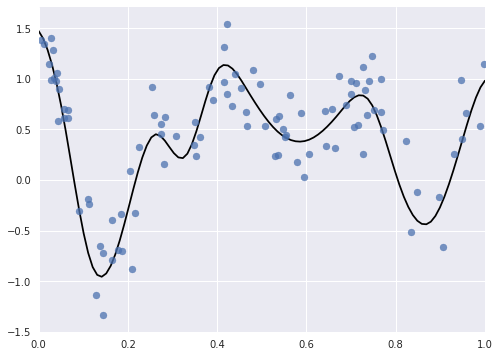

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, spline(x_plot), c='k');
ax.scatter(x, y, alpha=0.75, zorder=5);

ax.set_xlim(0, 1);

In [8]:
N_MODEL_KNOTS = 5 * N_KNOT
model_knots = np.linspace(-0.5, 1.5, N_MODEL_KNOTS)

basis_funcs = sp.interpolate.BSpline(knots, np.eye(N_MODEL_KNOTS), k=3)
Bx = basis_funcs(x)

Many thanks to [Adrian Seyboldt](https://github.com/aseyboldt) for pointing out a reparameterization that mixes better than the `GaussianRandomWalk`.

In [9]:
Bx_ = shared(Bx)

with pm.Model() as model:
    σ_a = pm.HalfCauchy('σ_a', 5.)
    a0 = pm.Normal('a0', 0., 10.)
    Δ_a = pm.Normal('Δ_a', 0., 1., shape=N_MODEL_KNOTS)
    a = pm.Deterministic('a', a0 + (σ_a * Δ_a).cumsum())
    
    σ = pm.HalfCauchy('σ', 5.)
    
    obs = pm.Normal('obs', Bx_.dot(a), σ, observed=y)

In [10]:
with model:
    trace = pm.sample(nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 105.09: 100%|██████████| 200000/200000 [00:44<00:00, 4517.58it/s]
Finished [100%]: Average Loss = 105.09
100%|██████████| 1000/1000 [01:51<00:00, 10.56it/s]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


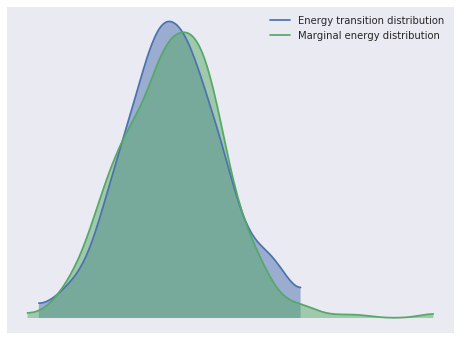

In [11]:
pm.energyplot(trace);

In [12]:
Bx_.set_value(basis_funcs(x_plot))

with model:
    pp_trace = pm.sample_ppc(trace, 1000)

100%|██████████| 1000/1000 [00:22<00:00, 44.44it/s]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


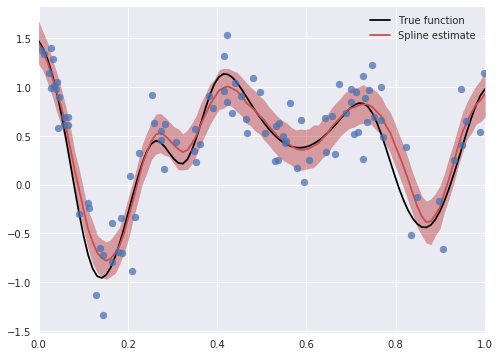

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, spline(x_plot),
        c='k', label="True function");

low, high = np.percentile(pp_trace['obs'], [25, 75], axis=0)
ax.fill_between(x_plot, low, high,
                color=red, alpha=0.5);
ax.plot(x_plot, pp_trace['obs'].mean(axis=0),
        c=red, label="Spline estimate");

ax.scatter(x, y, alpha=0.75, zorder=5);

ax.set_xlim(0, 1);

ax.legend();